## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('../../dataset/main/train.csv')
test = pd.read_csv('../../dataset/main/test.csv')

## Data Cleansing

### Handle Missing Values

In [3]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Dapat dilihat bahwa tidak ada missing value dalam dataset

### Handle Duplicacted Data

In [4]:
train.duplicated(subset=['id']).sum()

0

In [5]:
train.drop('id', axis=1 ,inplace=True)
test.drop('id', axis=1 ,inplace=True)

Dapat dilihat bahwa pada kolom 'id' tidak ada data duplikat yang ditemukan, sehingga dapat disimpulkan bahwa tidak ada data duplikat dalam dataset ini.

### Handlle Outliers

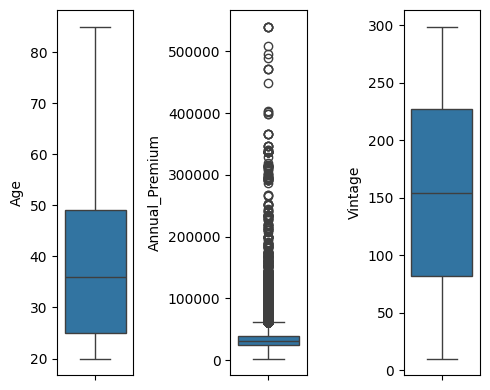

In [6]:
nums = ["Age","Annual_Premium","Vintage"]

plt.figure(figsize=(5, 4))
for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=train[nums[i]], orient='v')
    plt.tight_layout()

Setelah dilakukan pengecekan outlier pada kolom numerikal dengan menggunakan boxplot didapat bahwa kolom 'Age' dan 'Vintage' tidak memiliki outlier, sedangakan pada kolom 'Annual_Premium' terdapat outliers.

In [7]:
def remove_outliers_iqr(dataframe, column_name):
    # Calculate the IQR
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to exclude outliers
    filtered_dataframe = dataframe[(dataframe[column_name] >= lower_bound) & (dataframe[column_name] <= upper_bound)]

    # Display information about the removed outliers
    outliers_removed = dataframe.shape[0] - filtered_dataframe.shape[0]
    print(f"Number of outliers removed in '{column_name}': {outliers_removed}")

    return filtered_dataframe

Karena visualisasi outlier dilakukan menggunakan boxplot, maka penghapusan outlier akan menggunakan metode IQR 

Number of outliers removed in 'Annual_Premium': 10320


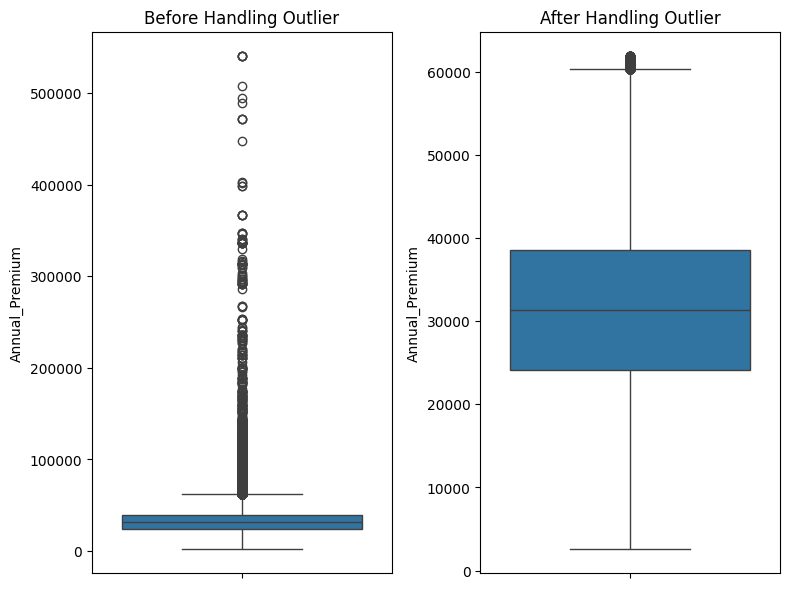

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.boxplot(train['Annual_Premium'], ax=axes[0])
axes[0].set_title('Before Handling Outlier')

# Using IQR to handle outlier
train = remove_outliers_iqr(train, 'Annual_Premium')

sns.boxplot(train['Annual_Premium'], ax=axes[1])
axes[1].set_title('After Handling Outlier')

plt.tight_layout()
plt.show()

Dapat dilihat outlier sudah terhapus sebanyak 1320, dapat dilihat pada boxplot bahwa range dari data annual premium sudah masuk ke dalam range boxplot yang lama

### Feature Transformation

In [9]:
nums = ['Age', 'Annual_Premium', 'Vintage']

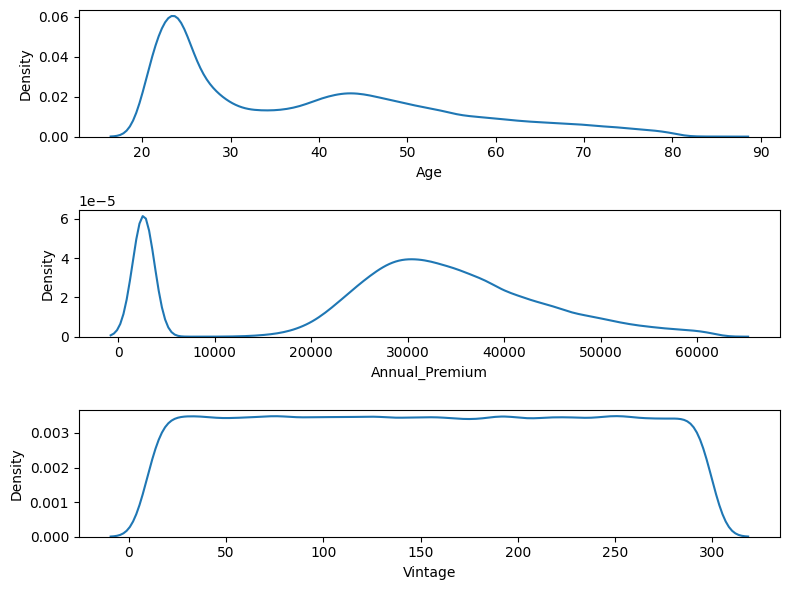

In [10]:
plt.figure(figsize=(8, 6))
for i in range(0, len(nums)):
    plt.subplot(len(nums), 1, i+1)
    sns.kdeplot(train[nums[i]])
    plt.tight_layout()

Dapat dilihat bahwa persebaran fitur numerik pada daset ini belum normal. Selanjutnya, pada annual_premium dapat dilihat bahwa range yang dimiliki sangat berbeda jauh dari kedua fitur numerik lainnya. Maka dari itu, Transformasi fitur akan menggunakan Log Tranformation untuk membuat distribusi fitur lebih simetrik.

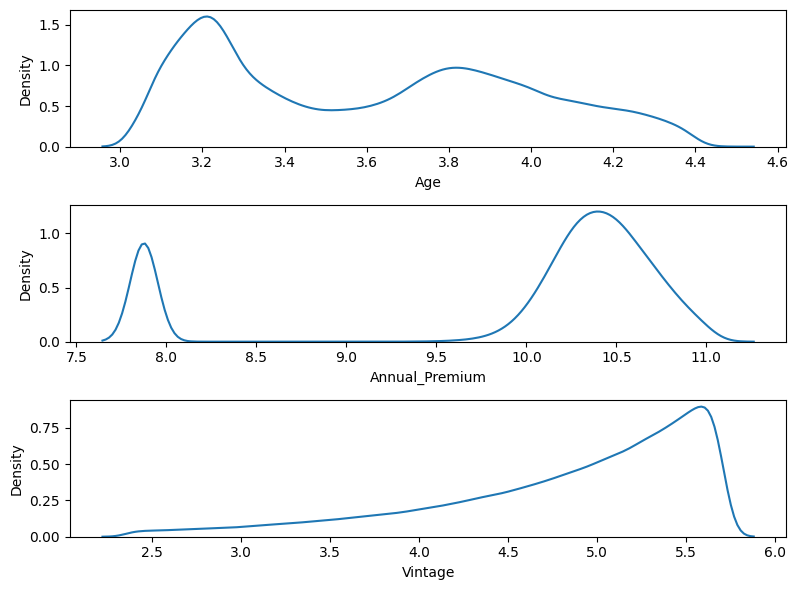

In [11]:
plt.figure(figsize=(8, 6))
for i in range(0, len(nums)):
    # Do Log Transformation
    train[nums[i]] = np.log1p(train[nums[i]])
    test[nums[i]] = np.log1p(train[nums[i]])

    # Plot the result
    plt.subplot(len(nums), 1, i+1)
    sns.kdeplot(train[nums[i]])
    plt.tight_layout()

### Feature Encodinng

Feature encoding akan dilakukan terhadap variable kategorikal supaya menjadi variable numerik dengan label encoding

In [12]:
cats = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [13]:
train[cats].describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,370789,370789,370789
unique,2,3,2
top,Male,1-2 Year,Yes
freq,200319,194212,186561


Di bawah ini adalah label encoding untuk fitur kategorikal yang ada 

In [14]:
mapping_gender = {
     'Male' : 0,
     'Female' : 1
}

mapping_vehicle_age = {
     '< 1 Year' : 0,
     '1-2 Year' : 1,
     '> 2 Years' : 2
}

mapping_vehicle_damage = {
     'No' : 0,
     'Yes' : 1
}

Label encoding akan dilakukan pada train dan test agar fitur yang dimasukkan ke dalam model machine learning dapat direpresentasikan sebagai nilai numerik. 

In [15]:
train['Gender'] = train['Gender'].map(mapping_gender)
test['Gender'] = test['Gender'].map(mapping_gender)

In [16]:
train['Vehicle_Age'] = train['Vehicle_Age'].map(mapping_vehicle_age)
test['Vehicle_Age'] = test['Vehicle_Age'].map(mapping_vehicle_age)

In [17]:
train['Vehicle_Damage'] = train['Vehicle_Damage'].map(mapping_vehicle_damage)
test['Vehicle_Damage'] = test['Vehicle_Damage'].map(mapping_vehicle_damage)

### Handle Class Imbalance

In [18]:
train.Response.value_counts()

Response
0    325634
1     45155
Name: count, dtype: int64

Dapat dilihat, hasil response menunjukkan bahwa terjadi class imbalance antara response 0 dan 1.

In [19]:
X_train = train.drop('Response', axis=1)
y_train = train['Response']

Pada penelitian ini, kami akan menggunakan undersampling karena ingin menangani ketidakseimbangan kelas dalam dataset. Undersampling membantu mengurangi jumlah instansi dari kelas mayoritas sehingga setiap kelas memiliki jumlah observasi yang lebih seimbang. 

Kami melakukan undersampling karena banyak data kelas minoritas masih cukup banyak dan kami beropini bahwa menggunakan data real lebih baik daripada membuat data sintetis menggunakan oversampling

In [20]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [21]:
train = pd.concat([X_train, y_train], axis=1)
train.Response.value_counts()

Response
0    45155
1    45155
Name: count, dtype: int64

Dapat dilihat, sekarang class response menjadi seimbang

In [22]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
255531,1,3.091042,1,46.0,1,0,0,10.325384,152.0,5.049856,0
27423,1,3.258097,1,46.0,1,0,0,10.485871,152.0,5.602119,0
253915,0,3.970292,1,46.0,1,1,1,10.198468,26.0,4.663439,0
167018,1,3.367296,1,18.0,1,0,0,10.979087,152.0,3.332205,0
26965,1,3.806662,1,11.0,0,1,1,10.411810,122.0,5.313206,0


## Feature Engineering

### Feature Extraction

Feature extraction akan dilakukan dengan membuat feature baru dari feature yang sudah ada. Feature extraction ini akan dilakukan pada data train dan test agar kedua data tersebut memiliki dimensi yang sama ketika dimasukkan ke dalam model.

#### Vintage Bin

In [23]:
train['Vintage'].describe()

count    90310.000000
mean         4.819421
std          0.763741
min          2.397895
25%          4.406719
50%          5.036953
75%          5.424950
max          5.703782
Name: Vintage, dtype: float64

In [24]:
q1 = train['Vintage'].quantile(0.25)
q2 = train['Vintage'].quantile(0.5)
q3 = train['Vintage'].quantile(0.75)

In [25]:
def label_encoding(vintage):
    if vintage <= q1:
        return 0
    elif vintage <= q2:
        return 1
    else:
        return 2

In [26]:
train['Vintage_Binned'] = train['Vintage'].apply(label_encoding)
test['Vintage_Binned'] = test['Vintage'].apply(label_encoding)

#### Age Bin

In [27]:
train['Age'].describe()

count    90310.000000
mean         3.669481
std          0.349566
min          3.044522
25%          3.332205
50%          3.713572
75%          3.931826
max          4.430817
Name: Age, dtype: float64

In [28]:
q1 = train['Age'].quantile(0.25)
q2 = train['Age'].quantile(0.5)
q3 = train['Age'].quantile(0.75)

In [29]:
def label_encoding(age):
    if age <= q1:
        return 0
    elif age <= q2:
        return 1
    else:
        return 2

In [30]:
train['Age_Bin'] = train['Age'].apply(label_encoding)
test['Age_Bin'] = test['Age'].apply(label_encoding)

#### Premium to Age Ratio

In [31]:
train['Premium_to_Age_Ratio'] = train['Annual_Premium'] / train['Age']

In [32]:
test['Premium_to_Age_Ratio'] = test['Annual_Premium'] / test['Age']

#### Age and Vehicle Age

In [33]:
train['Age_Vehicle_Age_Interaction'] = train['Age_Bin'] * train['Vehicle_Age']

In [34]:
test['Age_Vehicle_Age_Interaction'] = test['Age_Bin'] * test['Vehicle_Age']

#### Vehicle Damage dan Age

In [35]:
train['Vehicle_Damage_Age_Interaction'] = train['Age_Bin'] * train['Vehicle_Damage']

In [36]:
test['Vehicle_Damage_Age_Interaction'] = test['Age_Bin'] * test['Vehicle_Damage']

#### Save Result

In [37]:
train['Response'] = train.pop('Response')
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vintage_Binned,Age_Bin,Premium_to_Age_Ratio,Age_Vehicle_Age_Interaction,Vehicle_Damage_Age_Interaction,Response
255531,1,3.091042,1,46.0,1,0,0,10.325384,152.0,5.049856,2,0,3.340421,0,0,0
27423,1,3.258097,1,46.0,1,0,0,10.485871,152.0,5.602119,2,0,3.218404,0,0,0
253915,0,3.970292,1,46.0,1,1,1,10.198468,26.0,4.663439,1,2,2.568695,2,2,0
167018,1,3.367296,1,18.0,1,0,0,10.979087,152.0,3.332205,0,1,3.260506,0,0,0
26965,1,3.806662,1,11.0,0,1,1,10.411810,122.0,5.313206,2,2,2.735155,2,2,0


In [38]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vintage_Binned,Age_Bin,Premium_to_Age_Ratio,Age_Vehicle_Age_Interaction,Vehicle_Damage_Age_Interaction
0,0,1.570003,1,11.0,1,0,0,2.451690,152.0,1.853872,0,0,1.561583,0,0
1,0,1.675938,1,28.0,0,1,1,2.435402,7.0,1.826955,0,0,1.453157,0,0
2,0,1.583341,1,28.0,0,1,1,2.446952,124.0,1.466077,0,0,1.545436,0,0
3,0,1.408800,1,27.0,1,0,1,2.421422,152.0,1.843422,0,0,1.718784,0,0
4,0,1.481877,1,28.0,1,0,0,2.417861,152.0,1.545194,0,0,1.631621,0,0


In [39]:
train.to_csv('../../dataset/after_extraction/train.csv', index=False)
test.to_csv('../../dataset/after_extraction/test.csv', index=False)

In [40]:
train = pd.read_csv('../../dataset/after_extraction/train.csv')
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vintage_Binned,Age_Bin,Premium_to_Age_Ratio,Age_Vehicle_Age_Interaction,Vehicle_Damage_Age_Interaction,Response
0,1,3.091042,1,46.0,1,0,0,10.325384,152.0,5.049856,2,0,3.340421,0,0,0
1,1,3.258097,1,46.0,1,0,0,10.485871,152.0,5.602119,2,0,3.218404,0,0,0
2,0,3.970292,1,46.0,1,1,1,10.198468,26.0,4.663439,1,2,2.568695,2,2,0
3,1,3.367296,1,18.0,1,0,0,10.979087,152.0,3.332205,0,1,3.260506,0,0,0
4,1,3.806662,1,11.0,0,1,1,10.411810,122.0,5.313206,2,2,2.735155,2,2,0


### Feature Selection

<Axes: >

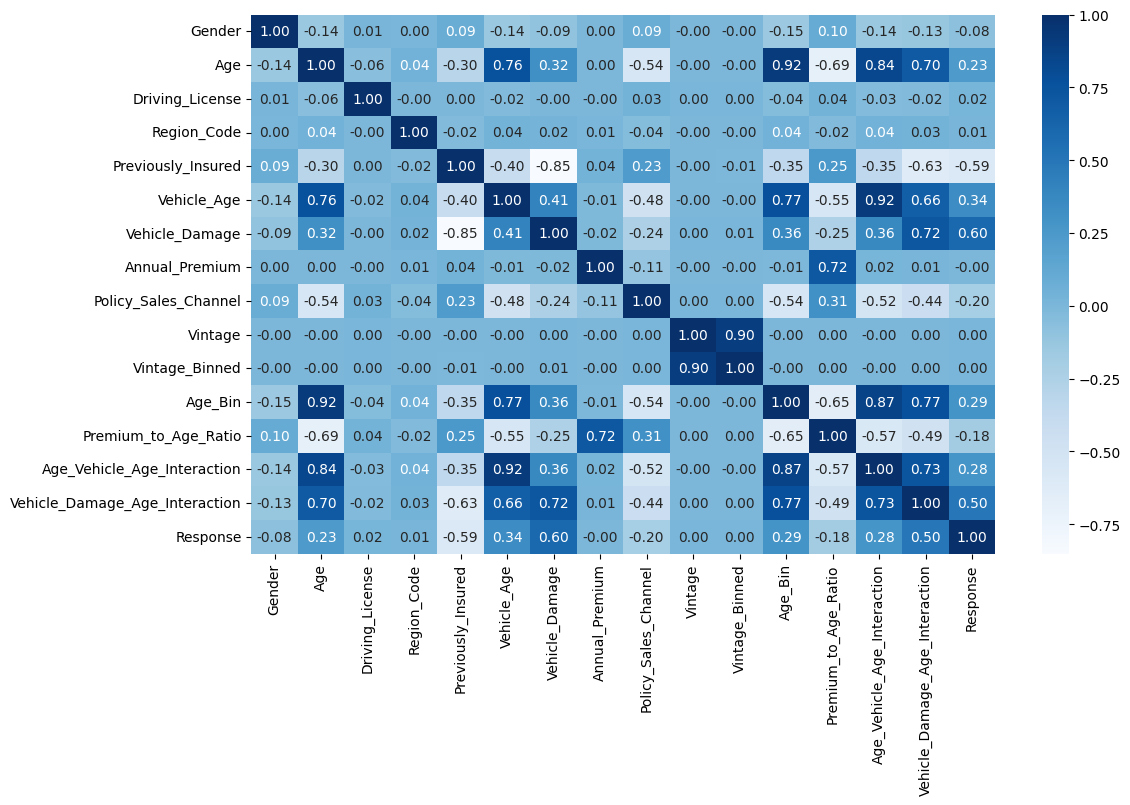

In [41]:
plt.figure(figsize=(12, 7))
sns.heatmap(train.corr(), cmap='Blues', annot=True, fmt='.2f')

### 2. feature selection berdasarkan korelasi antara feature yang bernilai redundant/ > 0.85
    
   * Age dengan Age Bin (Age Di hapus)

      Age dengan Age Bin,  bernilai Redundant yaitu 0,92 maka salah satu tersebut harus dihapus dengan pertimbangan diantara kedua feature tersebut mana yang memiliki korelasi paling tinggi terhadap Response

        Age terhadap target/ Response = 0.11
        Age Bin terhadap target/ Response = 0.29
      
      Maka yang di hapus adalah feature Age

  * Vehicle Age dengan Age vehicle Age Interaction (Age vehicle Age Interaction di hapus)

      Vehicle Age dengan Age vehicle Age Interaction bernilai Redundant yaitu 0,92 maka salah satu tersebut harus dihapus dengan pertimbangan diantara kedua feature tersebut mana yang memiliki korelasi paling tinggi terhadap Response
     
        Vehicle Age terhadap target/ Response = 0.34
        Age vehicle Age Interactionterhadap target/ Response = 0.28
    
    Maka Age vehicle Age Interaction di hapus dari data set

  * Vintage dengan Vintage Binned (vintage Binned)

      Vintage dengan Vintage Binbernilai Redundant yaitu 0,90 maka salah satu tersebut harus dihapus dengan pertimbangan diantara kedua feature tersebut mana yang memiliki korelasi paling tinggi terhadap Response
    
        Vintage terhadap target/ Response = 0.00
        Vintage Binned hadap target/ Response = 0.00
    
    Karena kedua nilai tersebut sama, maka salah satunya harus tetap di hapus yaitu Vintage Binned
      
  * Previously_Insured dengan Vehicle_Damage benilai Redundant yaitu -0.82, akan tetapi di pertahankan    dengan pertimbangan :
    
      kedua feature bernilai Redundant yaitu -0.82 akan tetapi jika berasumsi terhadap kolom tersebut penting dalam menentukan response 0 atau 1 , kalau dilihat dari distribusinya Previously_Insured (customer sudah memiliki asuransi kendaraan atau belum) banyak berpengaruh pada response 1, begitu juga dengan Vehicle_Damage (customer pernah mengalami kerusakan kendaraan atau belum) terhadap response bernilai 1  distribusinya pada data set cukup banyak, bisa jadi karena pernah mengalami kerusakan kendaraan jadi customer tertarik untuk berlangganan asuransi kendaraan.

  *  Annual_Premium dengan Premium to Age Ratio (Annual Premium di hapus dari data set)
    
       Premium_to_Age_Ratio dengan Annual_Premium bernilai redundant yaitu 0.76, maka salah satunya harus di hapus dengan pertimbangan diantara kedua feature tersebut mana yang memiliki korelasi paling tinggi terhadap target

       Premium_to_Age_Ratio terhadap target/ Response = 0.02
       Annual_Premium terhadap target/ Response = -0.08

       Maka Annual Premium di hapus dari data set.


### 1. Feature Selection berdasarkan pengujian untuk setiap Feature menggunakan Metode Mutual Information dan Chi-Square

In [42]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
# Membaca DataFrame dari file CSV
train = pd.read_csv('../../dataset/after_extraction/train.csv')
test = pd.read_csv('../../dataset/after_extraction/test.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90310 entries, 0 to 90309
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          90310 non-null  int64  
 1   Age                             90310 non-null  float64
 2   Driving_License                 90310 non-null  int64  
 3   Region_Code                     90310 non-null  float64
 4   Previously_Insured              90310 non-null  int64  
 5   Vehicle_Age                     90310 non-null  int64  
 6   Vehicle_Damage                  90310 non-null  int64  
 7   Annual_Premium                  90310 non-null  float64
 8   Policy_Sales_Channel            90310 non-null  float64
 9   Vintage                         90310 non-null  float64
 10  Vintage_Binned                  90310 non-null  int64  
 11  Age_Bin                         90310 non-null  int64  
 12  Premium_to_Age_Ratio            

In [43]:
# Menghilangkan kolom yang di hapus berdasarkan pearson corr. yang mengalami Redundan/ bernilai lebih dari 0.85
kolom_yang_dihapus = ['Response','Age','Age_Vehicle_Age_Interaction','Vintage_Binned','Annual_Premium']
features = train.drop(kolom_yang_dihapus, axis=1)

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90310 entries, 0 to 90309
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          90310 non-null  int64  
 1   Driving_License                 90310 non-null  int64  
 2   Region_Code                     90310 non-null  float64
 3   Previously_Insured              90310 non-null  int64  
 4   Vehicle_Age                     90310 non-null  int64  
 5   Vehicle_Damage                  90310 non-null  int64  
 6   Policy_Sales_Channel            90310 non-null  float64
 7   Vintage                         90310 non-null  float64
 8   Age_Bin                         90310 non-null  int64  
 9   Premium_to_Age_Ratio            90310 non-null  float64
 10  Vehicle_Damage_Age_Interaction  90310 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 7.6 MB


In [44]:
features.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Vintage,Age_Bin,Premium_to_Age_Ratio,Vehicle_Damage_Age_Interaction
0,1,1,46.0,1,0,0,152.0,5.049856,0,3.340421,0
1,1,1,46.0,1,0,0,152.0,5.602119,0,3.218404,0
2,0,1,46.0,1,1,1,26.0,4.663439,2,2.568695,2
3,1,1,18.0,1,0,0,152.0,3.332205,1,3.260506,0
4,1,1,11.0,0,1,1,122.0,5.313206,2,2.735155,2


#### Dilakukan Label Encoding untuk pengujian Mutual information dan Chi-Square karena feature harus bertipe kategorikal

In [45]:

from sklearn.preprocessing import LabelEncoder
for col in features.columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col])
features.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Vintage,Age_Bin,Premium_to_Age_Ratio,Vehicle_Damage_Age_Interaction
0,1,1,46,1,0,0,126,145,0,67718,0
1,1,1,46,1,0,0,126,260,0,60190,0
2,0,1,46,1,1,1,23,95,2,9178,2
3,1,1,18,1,0,0,126,17,1,63036,0
4,1,1,11,0,1,1,102,192,2,26460,2


### pengujian Mutual information dapat dilakukan dengan menggunakan tipe data kategorikal ataupun numerikal
 
 Dengan Pertimbangan nilai Mutal Information
 
* Mutal Information < 0.02: tidak bisa digunakan untuk prediksi
* 0.02 ≤ Mutal Information < 0.1: weak predictor
* 0.1 ≤ Mutal Information < 0.3: moderate predictor
* 0.3 ≤ Mutal Information < 0.5: strong predictor
* Mutal Information ≥ 0.5: suspicious predictor

In [46]:

# Mutual Information dengan feature encoding

mutual_info_values = mutual_info_classif(features, train['Response'])
print("\nMutual Information:")
for column, mi in zip(features.columns, mutual_info_values):
    print(f"{column}: {mi}")




Mutual Information:
Gender: 0.010075139236965347
Driving_License: 0.009229510028500698
Region_Code: 0.02716705287816512
Previously_Insured: 0.21935209444950332
Vehicle_Age: 0.06612771093484882
Vehicle_Damage: 0.22208837136211068
Policy_Sales_Channel: 0.0994431476255424
Vintage: 0.0007197479220757419
Age_Bin: 0.06518968345681131
Premium_to_Age_Ratio: 0.0676060755680794
Vehicle_Damage_Age_Interaction: 0.1786288359242445


In [47]:
# Mutual Information dengan data set tidak dilakukan encoding

mutual_info_values = mutual_info_regression(train, train['Response'])
print("\nMutual Information:")
for column, mi in zip(features.columns, mutual_info_values):
    print(f"{column}: {mi}")




Mutual Information:
Gender: 0.004524614624080492
Driving_License: 0.07415221448910003
Region_Code: 0.003399062270199593
Previously_Insured: 0.02200672060990616
Vehicle_Age: 0.21628757380179486
Vehicle_Damage: 0.06313078031153463
Policy_Sales_Channel: 0.21029808460242805
Vintage: 0.003027985475691608
Age_Bin: 0.09830280246170009
Premium_to_Age_Ratio: 0.001935210176485569
Vehicle_Damage_Age_Interaction: 0.0016270845750900875


### Penjelasan Feature Selection berdasarkan pengujian untuk setiap Feature menggunakan Metode Mutual Information

###  Mutual Information 

Mutual information menggunakan data set yang dilakukan label encoding (Kategorikal) dengan Mutual   information menggunakan data set yang tidak dilakukan label encoding (numerikal) memiliki nilai mutual_info_values yang tidak jauh berbeda.


Mutual Information tidak dilakukan label endoding:
* Gender: 0.003123553119994682
* Driving_License: 0.06975209749103684
* Region_Code: 0.0
* Previously_Insured: 0.026838975259560804
* Vehicle_Age: 0.22319677938428217
* Vehicle_Damage: 0.06264364544182577
* Policy_Sales_Channel: 0.21121699020381346
* Vintage: 0.0046138914641638
* Age_Bin: 0.09602409525249112
* Premium_to_Age_Ratio: 0.002209415337581788
* Vehicle_Damage_Age_Interaction: 0.0026198310921099477


Mutual Information dilakukan label endoding:
* Gender: 0.009850142892536384
* Driving_License: 0.00888954380142426
* Region_Code: 0.02342921450209956
* Previously_Insured: 0.22469129243372254
* Vehicle_Age: 0.0682555100059814
* Vehicle_Damage: 0.21959586490041993
* Policy_Sales_Channel: 0.10064080852039092
* Vintage: 0.0
* Age_Bin: 0.0670335023289077
* Premium_to_Age_Ratio: 0.06730438969765062
* Vehicle_Damage_Age_Interaction: 0.17833157319911885


Dapat dilihat dari nilai mutual_info_values dari kedua pengujian tersebut bahwa :
*  feature Vintage memiliki nilai < dari 0.02 di kedua pengujian, yang berarti feature tersebut tidak bisa digunakan untuk prediksi.
*  Feature Premium_to_Age_Ratio memiliki nilai < 0.02 di kedua pengujian, yang berarti feature tersebut tidak bisa digunakan untuk prediksi.
*  Feature Gender memiliki nilai < dari 0.02 di kedua pengujian, yang berarti feature tersebut tidak bisa digunakan untuk prediksi.

# Kesimpulan 

* Feature Vintage, Premium To Age Ratio, dan Gender harus di hapus dari data set berdasarkan pertimbangan dari hasil pengujian menggunakan metode Mutual Information


In [48]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vintage_Binned,Age_Bin,Premium_to_Age_Ratio,Age_Vehicle_Age_Interaction,Vehicle_Damage_Age_Interaction,Response
0,1,3.091042,1,46.0,1,0,0,10.325384,152.0,5.049856,2,0,3.340421,0,0,0
1,1,3.258097,1,46.0,1,0,0,10.485871,152.0,5.602119,2,0,3.218404,0,0,0
2,0,3.970292,1,46.0,1,1,1,10.198468,26.0,4.663439,1,2,2.568695,2,2,0
3,1,3.367296,1,18.0,1,0,0,10.979087,152.0,3.332205,0,1,3.260506,0,0,0
4,1,3.806662,1,11.0,0,1,1,10.411810,122.0,5.313206,2,2,2.735155,2,2,0


In [50]:

kolom_yang_dihapus = ['Age','Age_Vehicle_Age_Interaction','Vintage_Binned','Annual_Premium','Vintage','Premium_to_Age_Ratio','Gender']
# Menghilangkan kolom yang tidak dibutuhkan
train_after_selection = train.drop(kolom_yang_dihapus, axis=1)
test_after_selection= test.drop(kolom_yang_dihapus, axis=1)

train_after_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90310 entries, 0 to 90309
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Driving_License                 90310 non-null  int64  
 1   Region_Code                     90310 non-null  float64
 2   Previously_Insured              90310 non-null  int64  
 3   Vehicle_Age                     90310 non-null  int64  
 4   Vehicle_Damage                  90310 non-null  int64  
 5   Policy_Sales_Channel            90310 non-null  float64
 6   Age_Bin                         90310 non-null  int64  
 7   Vehicle_Damage_Age_Interaction  90310 non-null  int64  
 8   Response                        90310 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 6.2 MB


In [51]:
test_after_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Driving_License                 127037 non-null  int64  
 1   Region_Code                     127037 non-null  float64
 2   Previously_Insured              127037 non-null  int64  
 3   Vehicle_Age                     127037 non-null  int64  
 4   Vehicle_Damage                  127037 non-null  int64  
 5   Policy_Sales_Channel            127037 non-null  float64
 6   Age_Bin                         127037 non-null  int64  
 7   Vehicle_Damage_Age_Interaction  127037 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 7.8 MB


In [52]:
train_after_selection.to_csv('../../dataset/after_selection/train.csv', index=False)
test_after_selection.to_csv('../../dataset/after_selection/test.csv', index=False)

### Feature Tambahan

1. **Feature Income** 

    diperlukan untuk melihat penghasilan pelanggan yang dapat membantu mengidentifikasi kategori pelanggan yang lebih cocok untuk ditawarkan produk baru, seperti Asuransi Kendaraan Bermotor. Feature ini bertipe numerical

2. **Feature Retirement_Savings** 

    diperlukan untuk melihat Pelanggan yang sudah menyimpan uang untuk pensiun dapat dianggap sebagai kandidat yang tepat untuk menawarkan produk asuransi. Feature ini bertipe boolean

3. **Feature Vehicle** 

    adalah feature yang berisi berapa banyak pelanggan memiliki kendaraan. Kendaraan yang dimiliki pelanggan dapat memberikan gambaran tentang budget mereka untuk pembelian asuransi. Feature ini bertipe numerical

4. **Feature Home_Ownership** 

    adalah feature yang berisi apakah pelanggan memiliki rumah pribadi atau tidak. Status kepemilikan rumah pelanggan dapat memberikan gambaran tentang status keuangan mereka. Misalnya, pemilik rumah dapat dianggap lebih stabil finansial untuk mengambil alat asuransi yang mengandalkan pemilik rumah. Feature ini bertipe boolean

5. **Feature Employment_Status** 

    adalah feature yang berisi tentang status pekerjaan yang dimiliki nasabah, seperti contohnya Full-time, Intern, dll. Status pekerjaan pelanggan dapat memberikan informasi tambahan tentang preferensi mereka saat memilih asuransi. Feature bertipe Object